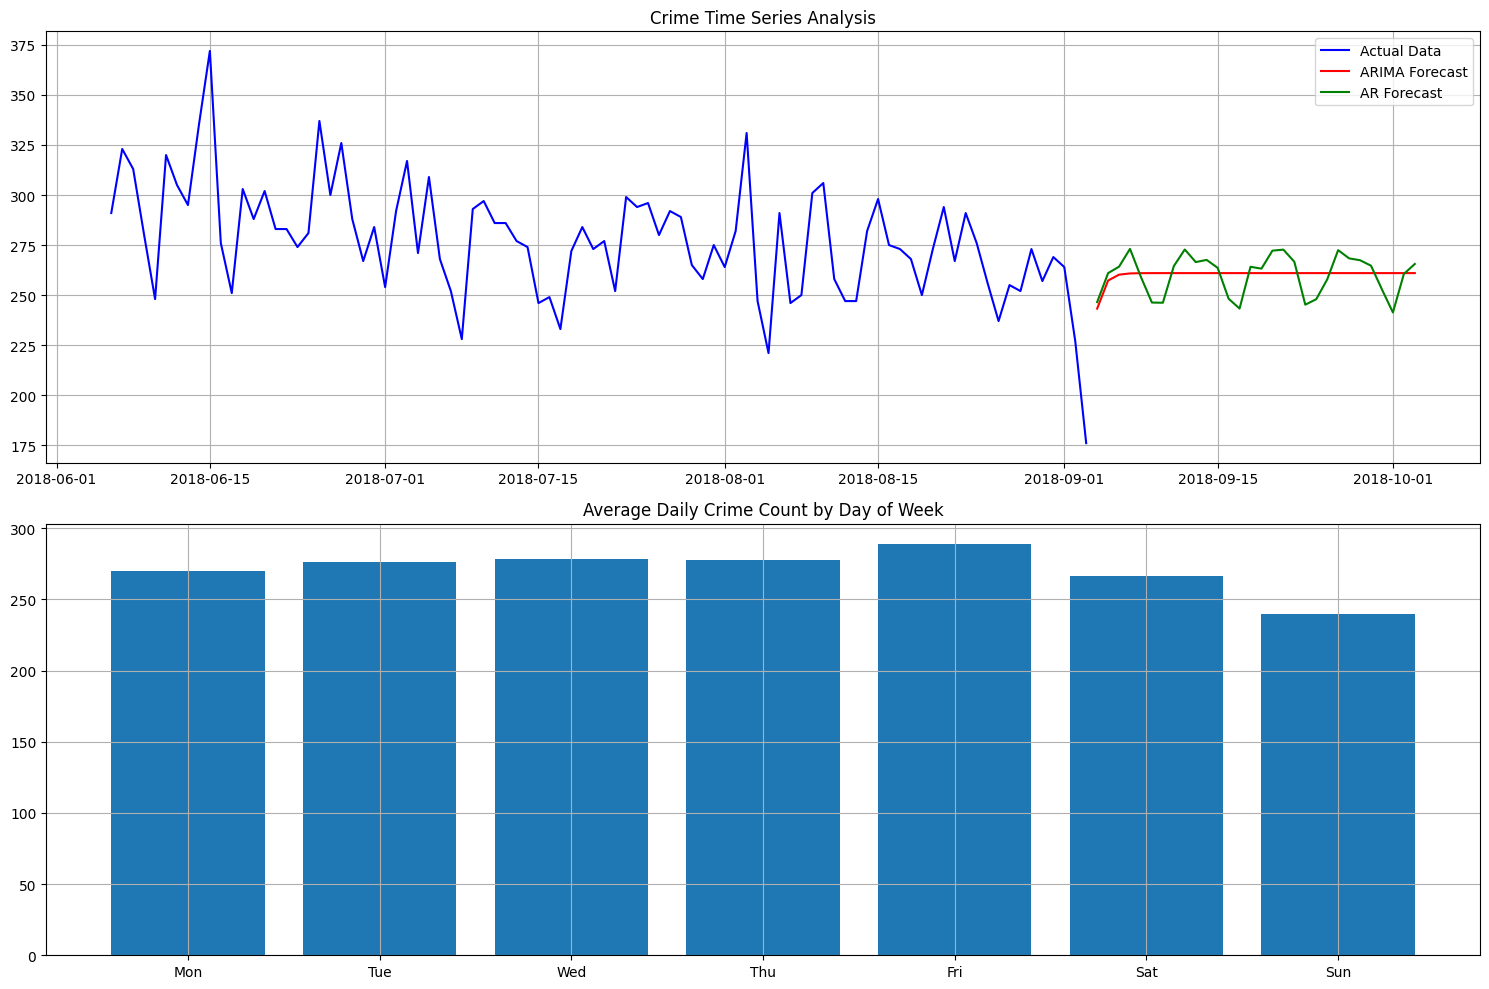


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1177
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5662.300
Date:                Sun, 17 Nov 2024   AIC                          11330.599
Time:                        22:35:29   BIC                          11345.809
Sample:                    06-15-2015   HQIC                         11336.334
                         - 09-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2088      0.031      6.756      0.000       0.148       0.269
ma.L1         -0.9479      0.010    -95.726      0.000      -0.967      -0.929
sigma2       889.1658     33.6

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

import matplotlib.pyplot as plt

# Read the data
crime_df = pd.read_csv('crime.csv', encoding='latin1')
offense_codes = pd.read_csv('offense_codes.csv', encoding='latin1')

# Convert OCCURRED_ON_DATE to datetime
crime_df['OCCURRED_ON_DATE'] = pd.to_datetime(crime_df['OCCURRED_ON_DATE'])

# Set date as index
crime_df.set_index('OCCURRED_ON_DATE', inplace=True)

# Create daily crime count
daily_crimes = crime_df.resample('D').size()

# Function to fit and forecast using ARIMA
def analyze_with_arima(series, order=(1,1,1)):
    # Fit ARIMA model
    model = ARIMA(series, order=order)
    results = model.fit()
    
    # Make predictions for next 30 days
    forecast = results.forecast(steps=30)
    
    return results, forecast

# Function to fit and forecast using AR
def analyze_with_ar(series, lags=30):
    # Fit AR model
    model = AutoReg(series, lags=lags)
    results = model.fit()
    
    # Make predictions for next 30 days
    forecast = results.forecast(steps=30)
    
    return results, forecast

# Analyze using both methods
arima_results, arima_forecast = analyze_with_arima(daily_crimes)
ar_results, ar_forecast = analyze_with_ar(daily_crimes)

# Plotting results
plt.figure(figsize=(15, 10))

# Plot 1: Original data and forecasts
plt.subplot(2, 1, 1)
plt.plot(daily_crimes.index[-90:], daily_crimes[-90:], label='Actual Data', color='blue')
plt.plot(pd.date_range(start=daily_crimes.index[-1], periods=31, freq='D')[1:], 
         arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(pd.date_range(start=daily_crimes.index[-1], periods=31, freq='D')[1:], 
         ar_forecast, label='AR Forecast', color='green')
plt.title('Crime Time Series Analysis')
plt.legend()
plt.grid(True)

# Plot 2: Crime by day of week
weekly_pattern = crime_df.resample('D').size().groupby(lambda x: x.dayofweek).mean()
plt.subplot(2, 1, 2)
plt.bar(range(7), weekly_pattern)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average Daily Crime Count by Day of Week')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nARIMA Model Summary:")
print(arima_results.summary())

print("\nAR Model Summary:")
print(ar_results.summary())

# Calculate and print error metrics
def print_error_metrics(actual, predicted, model_name):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    
    print(f"\n{model_name} Error Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

# Calculate error metrics for the last 30 days of data
actual_last30 = daily_crimes[-30:]
arima_fitted = arima_results.get_prediction(start=-30).predicted_mean
ar_fitted = ar_results.predict(start=len(daily_crimes)-30, end=len(daily_crimes)-1)

print_error_metrics(actual_last30, arima_fitted, "ARIMA")
print_error_metrics(actual_last30, ar_fitted, "AR")